# Import

In [1]:
import os, sys

import pandas as pd
import polars as pl

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import scipy

import sklearn
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import dproc, sgml, sgnn, sgpp, sgutil

print(sys.version)
for i in [pd, pl, mpl, sns, np, scipy, sklearn, lgb, xgb, cb]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

2025-02-05 01:14:10.614595: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-05 01:14:10.855871: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-05 01:14:11.585797: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


3.12.3 (main, May  1 2024, 17:33:23) [GCC 11.4.0]
pandas 2.2.2
polars 1.12.0
matplotlib 3.8.4
seaborn 0.13.2
numpy 1.26.4
scipy 1.13.0
sklearn 1.4.2
lightgbm 4.3.0
xgboost 2.1.2
catboost 1.2.5


In [2]:
from itertools import combinations

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

from scipy.stats import spearmanr, kruskal, chi2_contingency
from scipy.spatial.distance import cdist, pdist, squareform

# Download

In [3]:
for i in ['data', 'model', 'img', 'result']:
    if not os.path.exists(i):
        os.mkdir(i)

if not os.path.exists(os.path.join('data', 'train.csv')):
    !kaggle competitions download -c playground-series-s5e2
    !kaggle datasets download souradippal/student-bag-price-prediction-dataset
    !unzip student-bag-price-prediction-dataset.zip -d data
    !unzip playground-series-s5e2.zip -d data
    !rm playground-series-s5e2.zip
    !rm student-bag-price-prediction-dataset.zip

 99%|█████████████████████████████████████▋| 92.0M/92.7M [00:07<00:00, 15.0MB/s]
100%|██████████████████████████████████████| 92.7M/92.7M [00:07<00:00, 13.1MB/s]
Dataset URL: https://www.kaggle.com/datasets/souradippal/student-bag-price-prediction-dataset
License(s): MIT
 82%|███████████████████████████████       | 1.00M/1.23M [00:00<00:00, 3.48MB/s]
100%|██████████████████████████████████████| 1.23M/1.23M [00:00<00:00, 4.23MB/s]
Archive:  student-bag-price-prediction-dataset.zip
  inflating: data/Noisy_Student_Bag_Price_Prediction_Dataset.csv  
Archive:  playground-series-s5e2.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          
  inflating: data/training_extra.csv  


# Preparation

In [4]:
sc = sgutil.SGCache('img', 'result')
ss = ShuffleSplit(n_splits = 1, random_state = 123)
kf = KFold(5, random_state = 123, shuffle=True)

In [6]:
files = {
    'train': os.path.join('data', 'train.csv'),
    'train_extra': os.path.join('data', 'training_extra.csv'),
    'test': os.path.join('data', 'test.csv'),
    'org': os.path.join('data', 'Noisy_Student_Bag_Price_Prediction_Dataset.csv')
}

In [9]:
t = sc.cache_result(
    'pipeline_1',
    lambda : make_pipeline(
        sgpp.PolarsProcessor(), 
        sgpp.PandasCoverter(index_col = 'id'),
    ).fit(files['train']),
    rerun = 0
)
df_train = pd.concat(
    [t.transform(files['train']), t.transform(files['train_extra'])], axis = 0
)
df_test = t.transform(files['test'])
df_org = t.transform(files['org'])
df_org.set_index(-(df_org.index.rename('id') + 1), inplace=True)

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3994318 entries, 0 to 4194317
Data columns (total 10 columns):
 #   Column                Dtype   
---  ------                -----   
 0   Brand                 category
 1   Material              category
 2   Size                  category
 3   Compartments          float32 
 4   Laptop Compartment    category
 5   Waterproof            category
 6   Style                 category
 7   Color                 category
 8   Weight Capacity (kg)  float32 
 9   Price                 float32 
dtypes: category(7), float32(3)
memory usage: 87.6 MB


In [11]:
target = 'Price'
X_cat = df_train.dtypes.pipe(
    lambda x: x.loc[x == 'category'].index.tolist()
)
X_num = df_train.dtypes.pipe(
    lambda x: x.loc[(x != 'category') & (x.index != target)].index.tolist()
)
X_all = X_cat + X_num
target, X_cat, X_num

('Price',
 ['Brand',
  'Material',
  'Size',
  'Laptop Compartment',
  'Waterproof',
  'Style',
  'Color'],
 ['Compartments', 'Weight Capacity (kg)'])

In [12]:
def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size = validation_fraction)

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index = df.index).clip(15, 150),
    'score_func': lambda df, prds: root_mean_squared_error(df[target].sort_index(), prds.sort_index()),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'y': target,
}

cb_adapter = sgml.CBAdapter(cb.CatBoostRegressor)
lr_adapter = sgml.SklearnAdapter(LinearRegression)
lgb_adapter = sgml.LGBMAdapter(lgb.LGBMRegressor)
xgb_adapter = sgml.XGBAdapter(xgb.XGBRegressor)

# EDA

## Train / Test / Org Diff

In [14]:
X_cat_diff = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
X_num_diff = ['Compartments', 'Weight Capacity (kg)']
X_all_diff = X_cat_diff + X_num_diff

sc.cache_result(
    'train_test_diff',
    lambda : pd.concat([df_train[X_all_diff].assign(is_train = True), df_test[X_all_diff].assign(is_train = False)], axis = 0).dropna().pipe(
        lambda x: cross_val_score(lgb.LGBMClassifier(verbose = 0), x[X_all_diff], x['is_train'], cv = ss, scoring = 'roc_auc')
    )
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


array([0.49936197])

In [15]:
X_cat_diff = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
X_num_diff = ['Compartments', 'Weight Capacity (kg)', target]
X_all_diff = X_cat_diff + X_num_diff

sc.cache_result(
    'train_org_diff',
    lambda : pd.concat([df_train[X_all_diff].assign(is_train = True), df_org[X_all_diff].assign(is_train = False)], axis = 0).dropna().pipe(
        lambda x: cross_val_score(lgb.LGBMClassifier(verbose = 0), x[X_all_diff], x['is_train'], cv = ss, scoring = 'roc_auc')
    )
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


array([0.60704611])

In [16]:
X_cat_diff = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
X_num_diff = ['Compartments', 'Weight Capacity (kg)']
X_all_diff = X_cat_diff + X_num_diff

sc.cache_result(
    'org_test_diff',
    lambda : pd.concat([df_org[X_all_diff].assign(is_org = True), df_test[X_all_diff].assign(is_org = False)], axis = 0).dropna().pipe(
        lambda x: cross_val_score(lgb.LGBMClassifier(verbose = 0), x[X_all_diff], x['is_org'], cv = ss, scoring = 'roc_auc')
    )
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


array([0.60868605])

Although there appears to be some difference from the original data, the separation is not clear. It is worth investigating whether incorporating the original data might contribute to performance improvements.

## Missing Values

In [19]:
df_train[X_all].isna().mean().pipe(
    lambda x: x.loc[x > 0].rename('na_ratio').to_frame().T
)

,Brand,Material,Size,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
na_ratio,0.031735,0.02778,0.021977,0.024668,0.023615,0.026082,0.033452,0.000453


In [20]:
df_train[X_all].isna().sum(axis=1).value_counts(normalize=True)

0    0.823295
1    0.164755
2    0.010949
3    0.000902
4    0.000094
5    0.000005
Name: proportion, dtype: float64

## Target

In [21]:
df_train[target].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
Price,3994318.0,81.36219,38.938683,15.0,47.47002,80.984951,114.855003,150.0


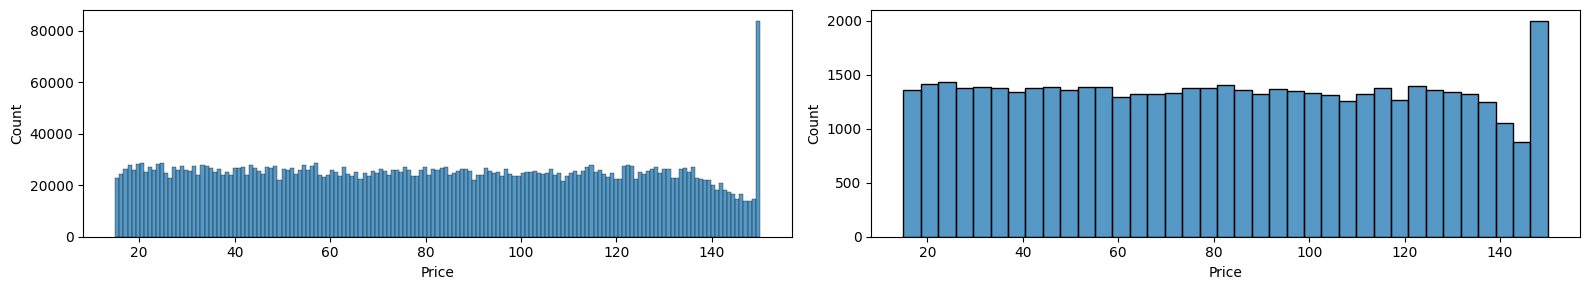

In [22]:
_, axes = plt.subplots(1, 2, figsize = (16, 3))
sns.histplot(df_train[target], ax = axes[0])
sns.histplot(df_org[target], ax = axes[1])
plt.tight_layout()
plt.show()

In [23]:
df_train[target].value_counts(normalize=True).iloc[:5]

Price
150.000000    0.018046
15.000000     0.002261
39.834351     0.000049
35.248440     0.000047
77.643898     0.000046
Name: proportion, dtype: float64

It is highly likely that the target has been clipped to values between 15 and 150.

## Categorical Variables

In [24]:
# Using Kruskal analysis, we examine the relationship between the categorical variables and the target.
sc.cache_result(
    'kruskal_target',
    lambda : pd.concat([
        pd.Series(
            kruskal(*df_train.groupby(i, observed=True)[target].agg(list)), index=['stat', 'pvalue'], name=i
        ) for i in X_cat
    ], axis=1), rerun = 0
).T.join(df_train[X_cat].nunique().rename('nunique')).sort_values('pvalue', ascending = True)

,stat,pvalue,nunique
Color,1112.049007,3.287018e-238,6
Material,984.716448,3.720285e-213,4
Brand,728.499502,2.349271e-156,5
Size,68.355244,1.434985e-15,3
Style,41.754788,8.571619e-10,3
Laptop Compartment,2.275337,1.314466e-01,2
Waterproof,0.810065,3.681010e-01,2


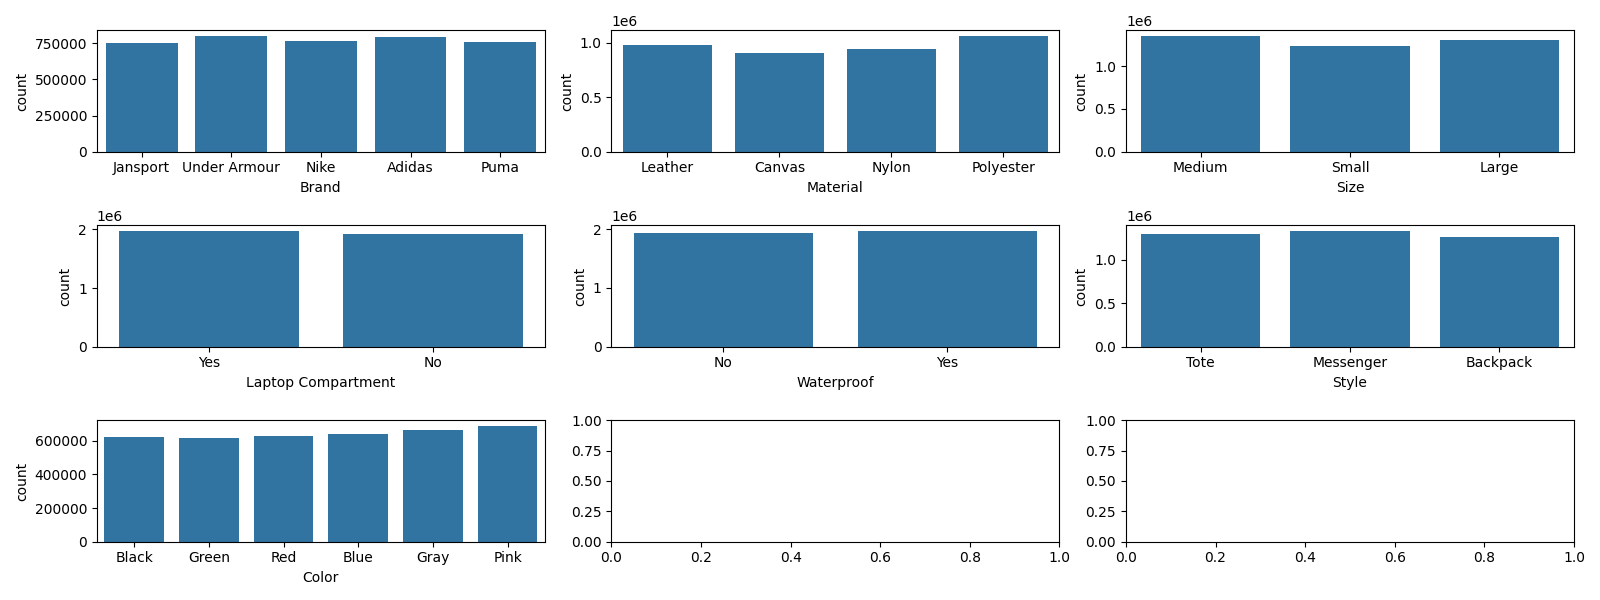

In [27]:
sc.cache_fig(
    'count_plot',
    lambda x: [sns.countplot(df_train, x = a, ax=b) for a, b in zip(X_cat, x)],
    3, 3, (16, 6), redraw = 0
)

In [28]:
# Using the chi-square independence test, we examine the relationships among the categorical variables.
pd.DataFrame(
    squareform(
        sc.cache_result(
            'chi2_variables',
            lambda : pdist(df_train[X_cat].T, lambda u, v: chi2_contingency(pd.crosstab(u, v)).pvalue)
        )
    ), index = X_cat, columns = X_cat
)

,Brand,Material,Size,Laptop Compartment,Waterproof,Style,Color
Brand,0.000000e+00,7.339322e-105,8.191573e-10,1.285559e-06,0.000427,1.556074e-38,1.222133e-38
Material,7.339322e-105,0.000000e+00,2.868779e-46,1.132307e-03,0.000122,3.001038e-26,3.601770e-50
Size,8.191573e-10,2.868779e-46,0.000000e+00,1.710983e-08,0.032685,7.383451e-20,6.085557e-23
Laptop Compartment,1.285559e-06,1.132307e-03,1.710983e-08,0.000000e+00,0.000000,4.068473e-05,3.895448e-03
Waterproof,4.274141e-04,1.222666e-04,3.268464e-02,0.000000e+00,0.000000,6.809984e-02,5.379369e-02
Style,1.556074e-38,3.001038e-26,7.383451e-20,4.068473e-05,0.068100,0.000000e+00,1.165345e-28
Color,1.222133e-38,3.601770e-50,6.085557e-23,3.895448e-03,0.053794,1.165345e-28,0.000000e+00


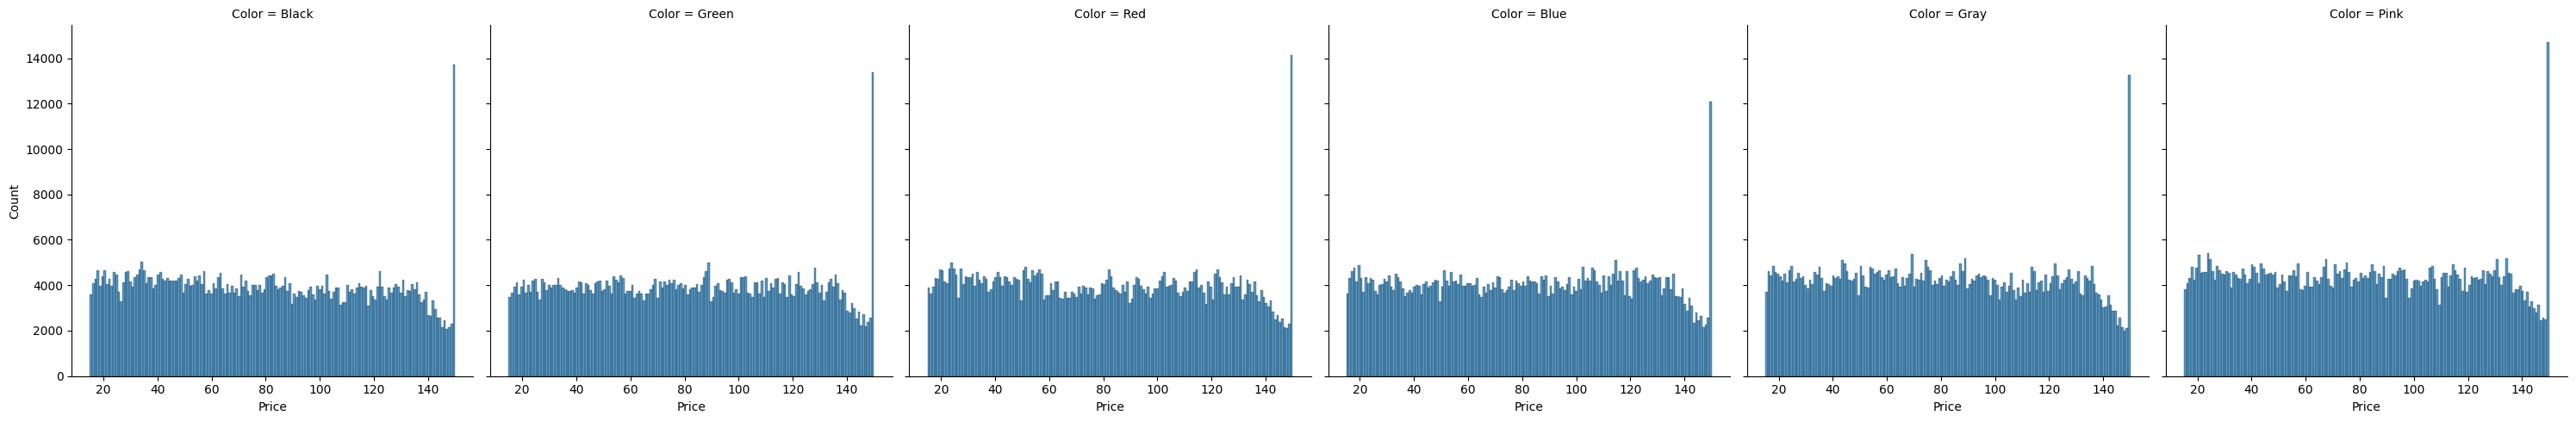

In [34]:
# According to the results of the Kruskal analysis, the Material attribute has the strongest association with the target. A histogram of the target is then plotted based on Material.
sns.displot(df_train, x = target , col = 'Color')
plt.show()

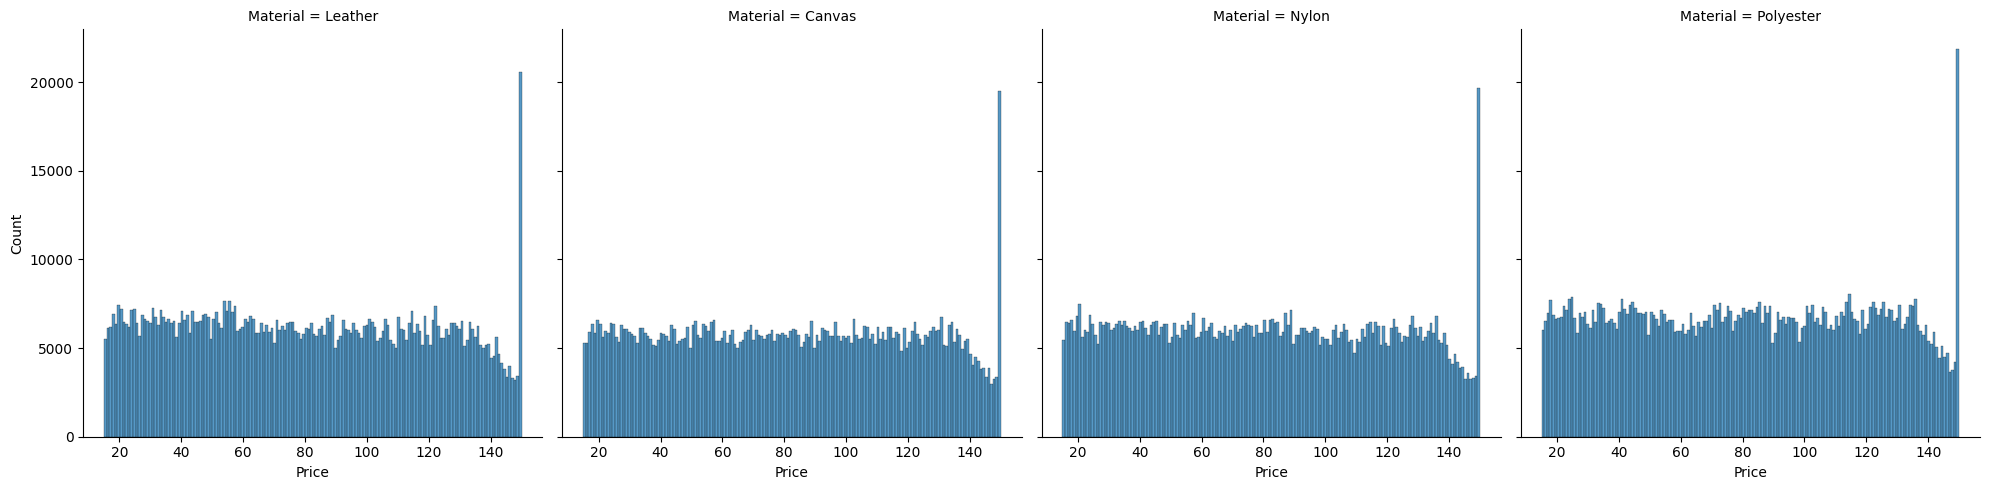

In [35]:
# The next strongest association with the target is Color.
sns.displot(df_train, x = target , col = 'Material')
plt.show()

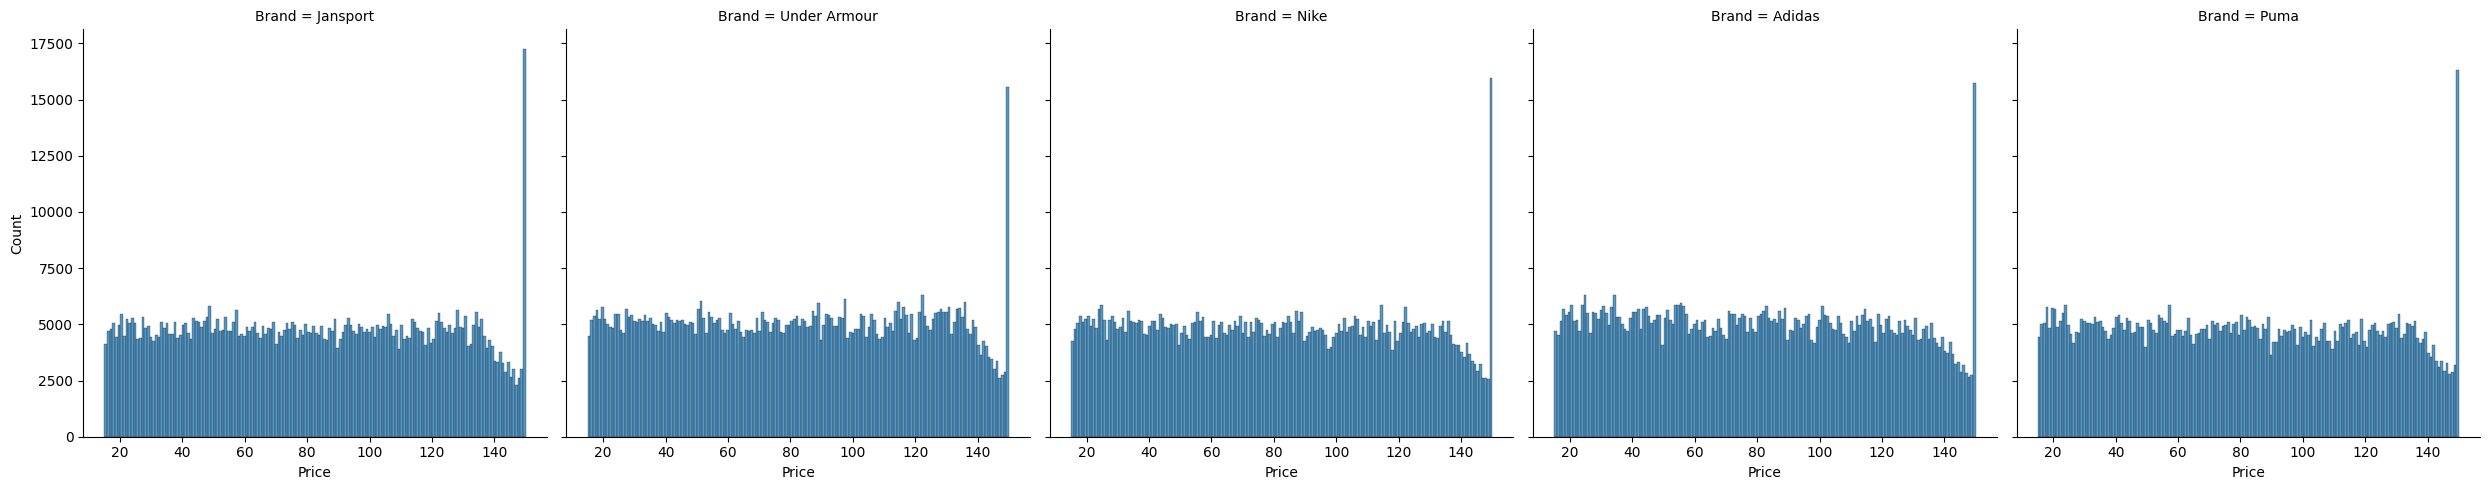

In [36]:
# The next strongest association with the target is Brand.
sns.displot(df_train, x = target , col = 'Brand')
plt.show()

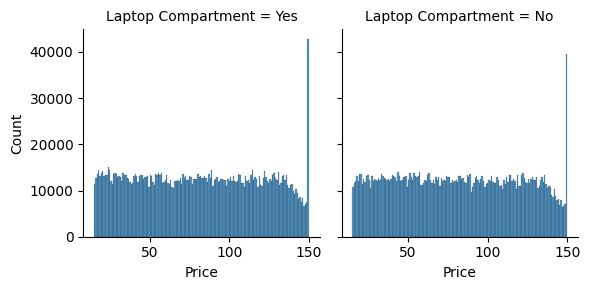

In [37]:
# The next strongest association with the target is Laptop Compartment.
sns.displot(df_train, x = target , col = 'Laptop Compartment', height = 3)
plt.show()

In [39]:
df_train.groupby('Color', observed = True)[target].median().to_frame().T

Color,Black,Green,Red,Blue,Gray,Pink
Price,79.232819,82.367554,80.833977,82.35083,80.019958,81.284637


In [38]:
df_train.groupby('Material', observed = True)[target].median().to_frame().T

Material,Leather,Canvas,Nylon,Polyester
Price,79.369537,81.717491,80.553726,82.057182


It is difficult to discern clear differences in the target through visualization.

<Axes: xlabel='count', ylabel='Count'>

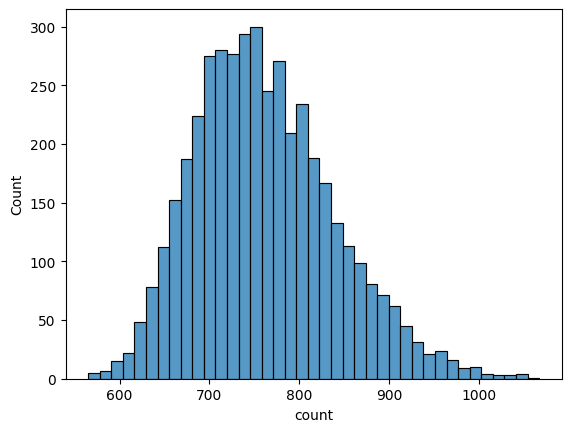

In [40]:
sns.histplot(df_train[X_cat].dropna().value_counts())

In [41]:
def rmse_tgt_enc_cat(X, cv = ss):
    tgt = TargetEncoder(random_state = 123, target_type  = 'continuous')
    rmse_list = list()
    for train_idx, valid_idx in cv.split(df_train[X], df_train[target]):
        df_cv_train, df_valid = df_train.iloc[train_idx], df_train.iloc[valid_idx]
        df_cv_train, df_valid = df_cv_train.dropna(), df_valid.dropna()
        if len(X) == 0:
            rmse_list.append(df_valid[target].std())
            continue
        if len(X) > 1:
            tgt.fit(dproc.combine_cat(df_cv_train[X]).to_frame(), df_cv_train[target])
            rmse_list.append(
                root_mean_squared_error(df_valid[target], tgt.transform(dproc.combine_cat(df_valid[X]).to_frame()))
            )
        else:
            tgt.fit(df_cv_train[X], df_cv_train[target])
            rmse_list.append(
                root_mean_squared_error(df_valid[target], tgt.transform(df_valid[X]))
            )
    return np.mean(rmse_list)

def get_comb_cat_rmse_tgt(n, cv = ss, X_cat = X_cat):
    return pd.Index(combinations(X_cat, n)).to_series().map(
        lambda x: rmse_tgt_enc_cat(list(x), cv)
    ).sort_values()

In [45]:
rmse_base = rmse_tgt_enc_cat([], ss)
rmse_base

38.7836

In [46]:
rmse_comb_cat_list = sc.cache_result(
    'comb_cat_rmse',
    lambda : [get_comb_cat_rmse_tgt(i, ss) for i in range(1, len(X_cat) + 1)], rerun = 0
)
for i in rmse_comb_cat_list:
    display(i.iloc[:5])

Color       38.776183
Material    38.779321
Brand       38.779404
Size        38.782986
Style       38.783226
dtype: float64

Material  Color       38.771576
Brand     Color       38.771769
          Material    38.774867
Size      Color       38.775691
Style     Color       38.775905
dtype: float64

Brand     Material  Color    38.766866
          Size      Color    38.771088
Material  Size      Color    38.771427
          Style     Color    38.771492
Brand     Style     Color    38.771574
dtype: float64

Brand  Material  Waterproof          Color    38.767333
                 Size                Color    38.767807
                 Laptop Compartment  Color    38.767930
                 Style               Color    38.768585
       Size      Style               Color    38.771141
dtype: float64

Brand  Material  Laptop Compartment  Waterproof          Color    38.768881
                 Size                Waterproof          Color    38.769344
                 Waterproof          Style               Color    38.769874
                 Size                Laptop Compartment  Color    38.770472
                 Laptop Compartment  Style               Color    38.770775
dtype: float64

Brand     Material  Size                Laptop Compartment  Waterproof  Color    38.773083
                    Laptop Compartment  Waterproof          Style       Color    38.773946
Material  Size      Laptop Compartment  Waterproof          Style       Color    38.775832
Brand     Material  Size                Waterproof          Style       Color    38.776419
          Size      Laptop Compartment  Waterproof          Style       Color    38.777105
dtype: float64

Brand  Material  Size  Laptop Compartment  Waterproof  Style  Color    38.790627
dtype: float64

## Numerical Variables

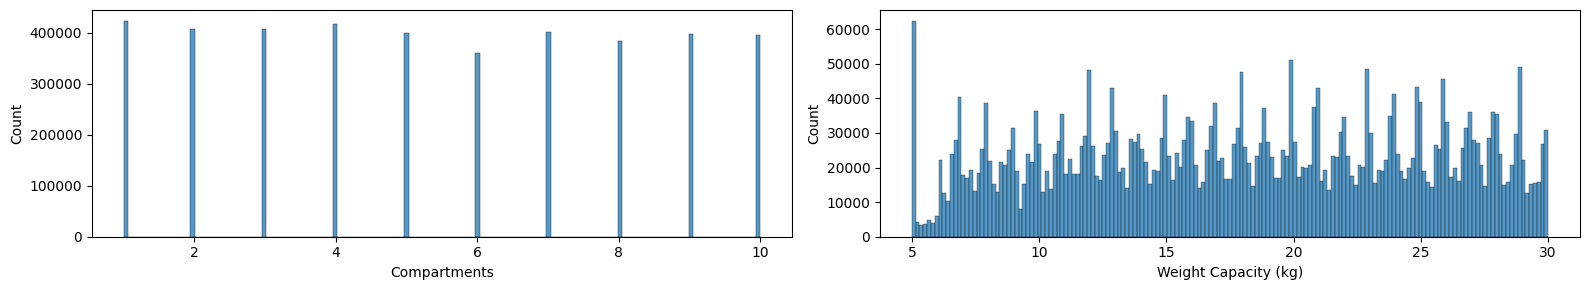

In [47]:
sc.cache_fig(
    'hist_plot',
    lambda x: [sns.histplot(df_train, x = a, ax=b) for a, b in zip(X_num, x)],
    1, 2, (16, 3), redraw = 0
)

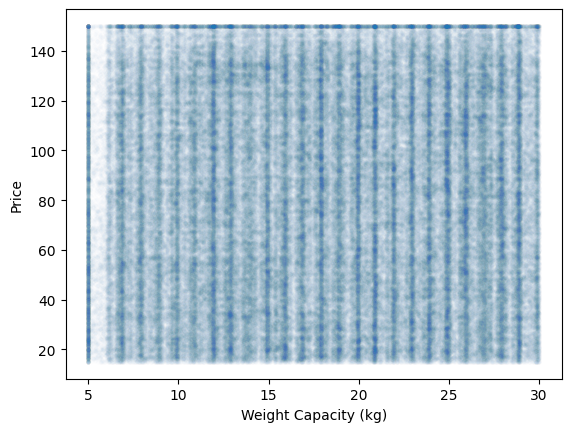

In [49]:
sns.scatterplot(
    df_train.sample(frac = 0.1), x = 'Weight Capacity (kg)', y = target, alpha = 0.01, s = 10
)
plt.show()

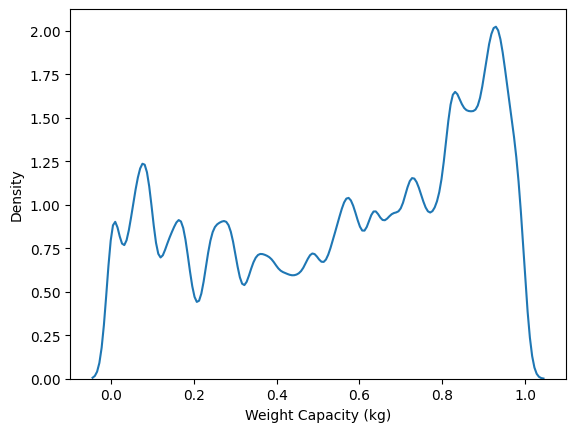

In [50]:
# hist. of floating part of Weight Capacity (kg)
sns.kdeplot(df_train['Weight Capacity (kg)'].dropna().pipe(lambda x: x - x.astype('int')))
plt.show()

Weight Capacity tends to be concentrated at points where the first decimal place is 0. It may be worth rounding to the nearest integer at the first decimal place.

In [51]:
# Spearman correlation between Target and the numerical variables.
df_train[X_num].apply(
    lambda x: pd.Series(spearmanr(x.loc[x.notna()], df_train.loc[x.notna(), target]), index = ['r', 'pvalue']), axis = 0
)    

,Compartments,Weight Capacity (kg)
r,-0.000734,1.728332e-02
pvalue,0.142302,2.248028e-261


In [52]:
# Spearman correlation of each pairs of the numerical variables.
df_train[X_num].corr()

,Compartments,Weight Capacity (kg)
Compartments,1.000000,0.003172
Weight Capacity (kg),0.003172,1.000000


In [53]:
# Kruskal of each pairs of the categorical variables and the numerical variables.
sc.cache_result(
    'kruskal_cat_num',
    lambda : df_train.dropna().pipe(
        lambda x: pd.concat([
            x.groupby(i, observed=True)[X_num].agg(list).apply(
                lambda x: pd.Series(kruskal(*x), index=['stat', 'pvalue']), axis = 0
            ).loc['pvalue'].rename(i)
            for i in X_cat
        ], axis=1)
    )
)

,Brand,Material,Size,Laptop Compartment,Waterproof,Style,Color
Compartments,4.936441e-19,1.683298e-20,2.066775e-09,1.198634e-06,2.628969e-07,1.708544e-41,0.005374
Weight Capacity (kg),7.239129e-19,2.240113e-66,4.234059e-19,4.538580e-10,5.059710e-13,2.765385e-04,0.016058


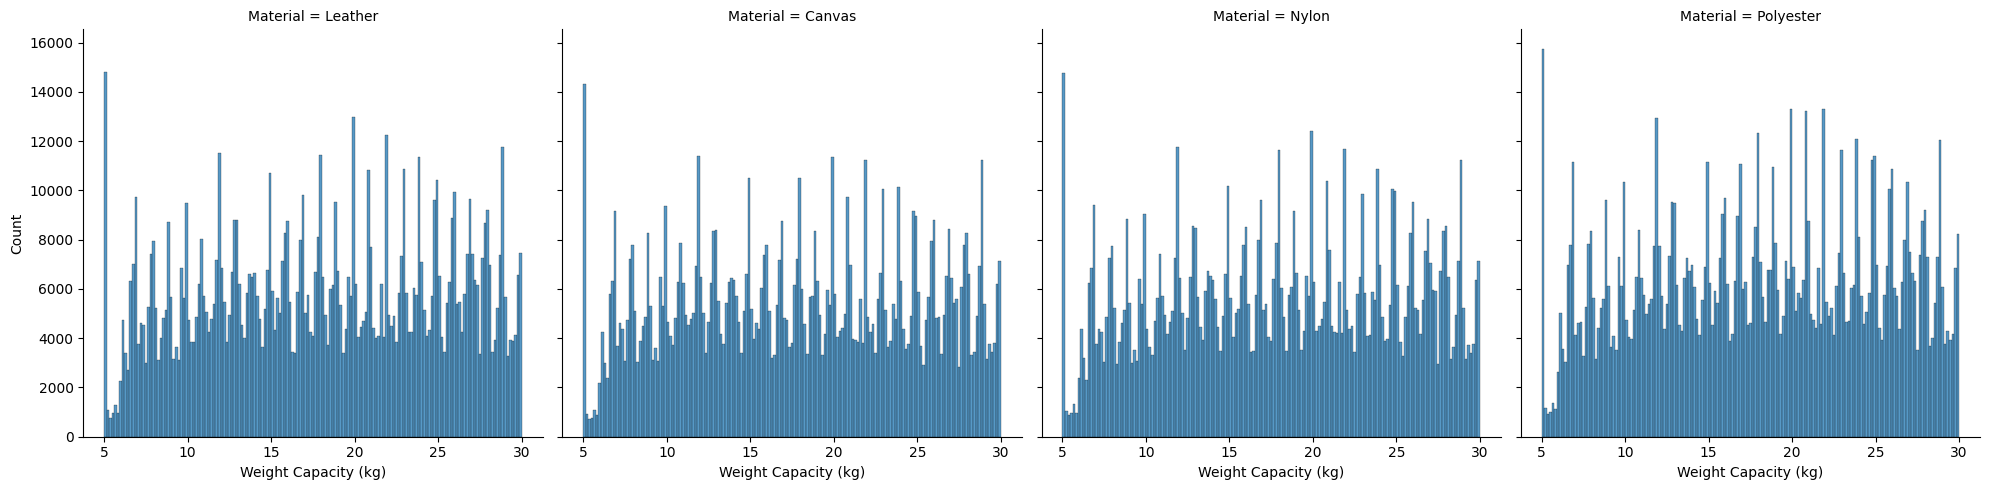

In [54]:
sns.displot(df_train, x = 'Weight Capacity (kg)', col = 'Material')
plt.show()

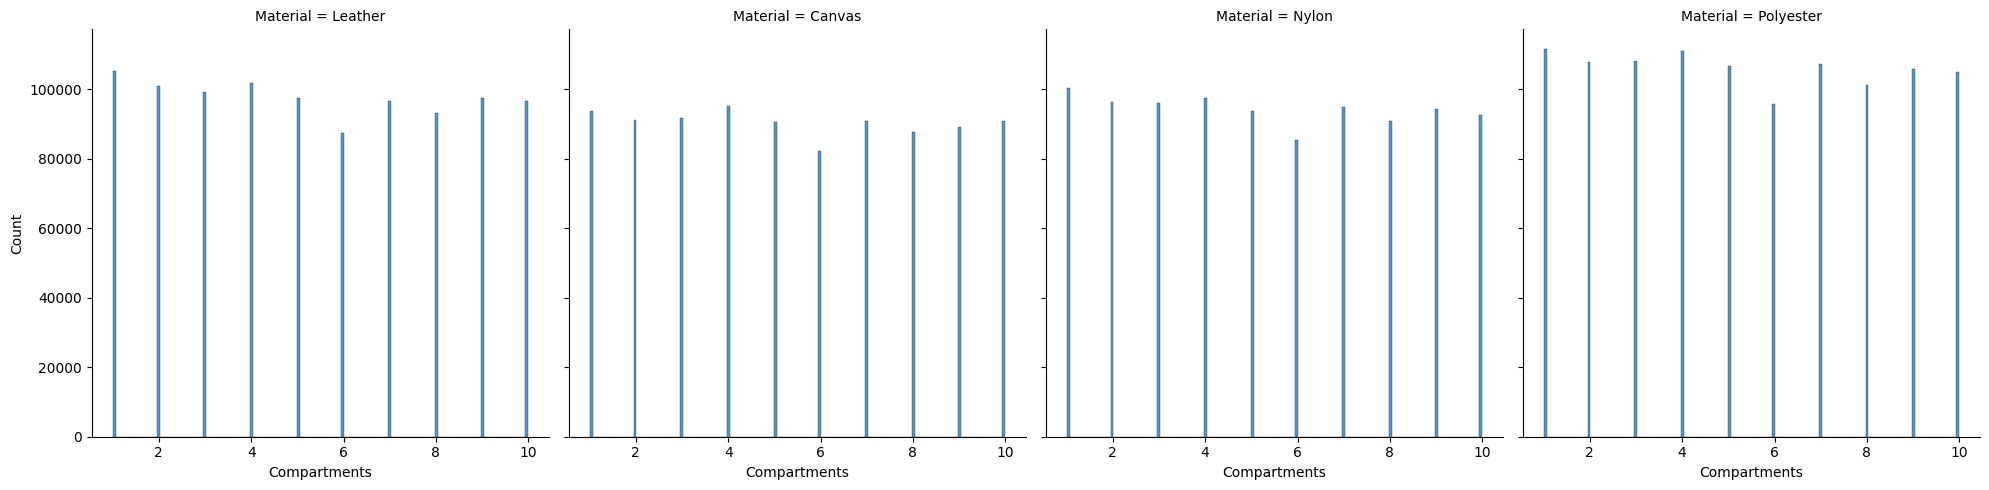

In [55]:
sns.displot(df_train, x = 'Compartments', col = 'Material')
plt.show()

In [56]:
df_train.groupby('Material', observed=True)[X_num].median()

,Compartments,Weight Capacity (kg)
Material,,
Leather,5.0,18.087772
Canvas,5.0,17.923660
Nylon,5.0,18.067928
Polyester,5.0,18.160501


In [57]:
df_train.groupby('Material', observed=True)['Compartments'].mean().to_frame().T

Material,Leather,Canvas,Nylon,Polyester
Compartments,5.419785,5.455309,5.432391,5.437785


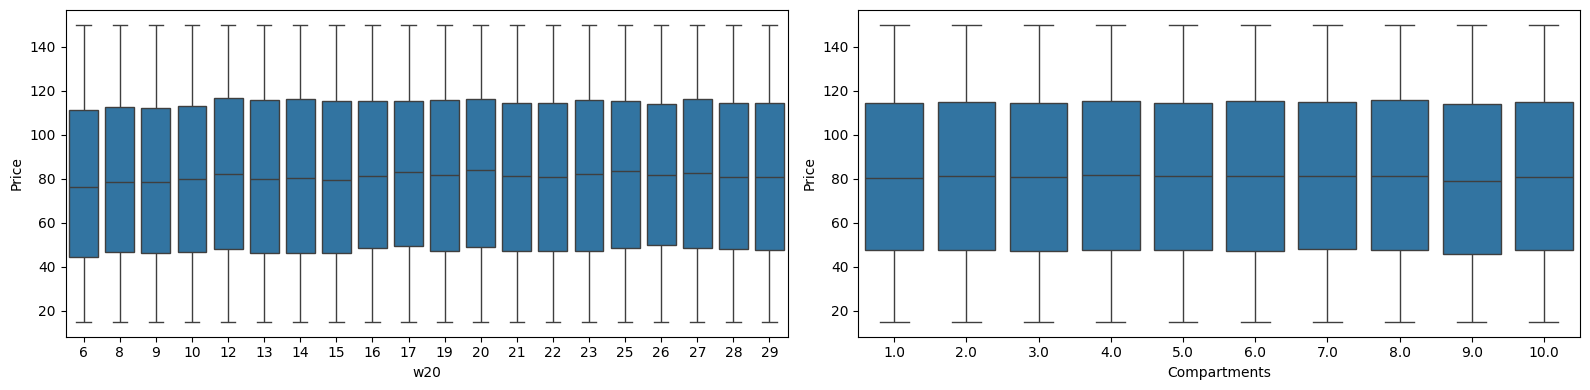

In [58]:
_, axes = plt.subplots(1, 2, figsize=(16, 4))
sns.boxplot(
    df_train.assign(
        w20 = pd.qcut(df_train['Weight Capacity (kg)'], q=20).pipe(lambda x: x.apply(lambda x: round((x.left + x.right) / 2))), observed=True
    ), x = 'w20', y = target, ax = axes[0]
)

sns.boxplot(
    df_train, x = 'Compartments', y = target,
    ax = axes[1]
)
plt.tight_layout()
plt.show()

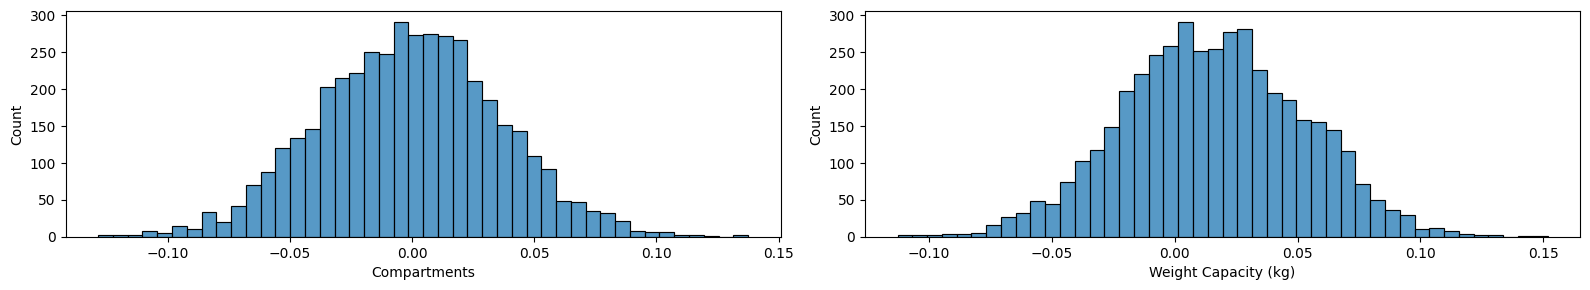

In [59]:
# We examine the distribution of the Spearman correlations between the Target and continuous variables, separated by categorical variables.
sc.cache_fig(
    'spearmanr_groupby_cat',
    lambda x: 
        [sns.histplot(df_train.dropna().groupby(X_cat, observed = True)[X_num + [target]].apply(
            lambda x: spearmanr(x[a], x[target]).statistic
        ).rename(a).to_frame(), x = a, ax=b) for a,b in zip(X_num, x)]
    , 1, 2, figsize = (16, 3), redraw = 0
)

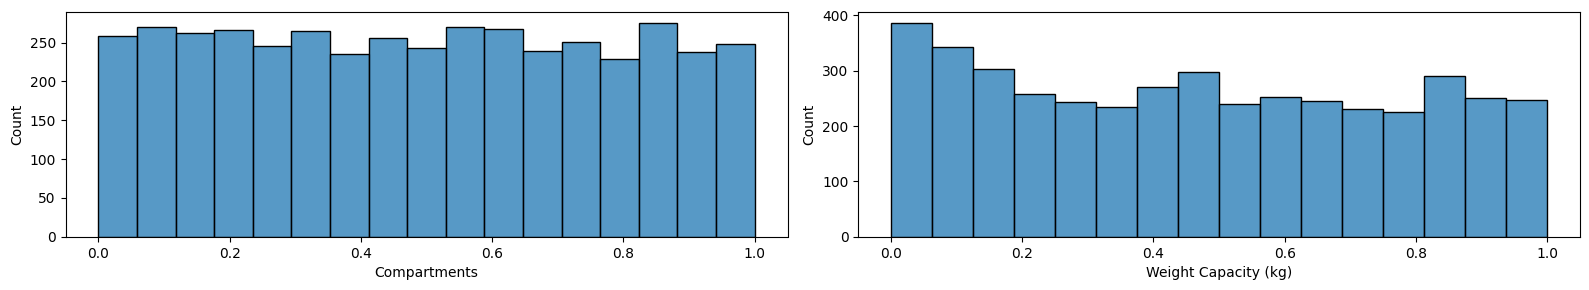

In [60]:
# We examine the distribution of the pvalues of Spearman correlations analysis between the Target and continuous variables, separated by categorical variables.
sc.cache_fig(
    'spearmanr_groupby_cat_pvalue',
    lambda x: 
        [sns.histplot(df_train.dropna().groupby(X_cat, observed = True)[X_num + [target]].apply(
            lambda x: spearmanr(x[a], x[target]).pvalue
        ).rename(a).to_frame(), x = a, ax=b) for a,b in zip(X_num, x)]
    , 1, 2, figsize = (16, 3), redraw = 0
)

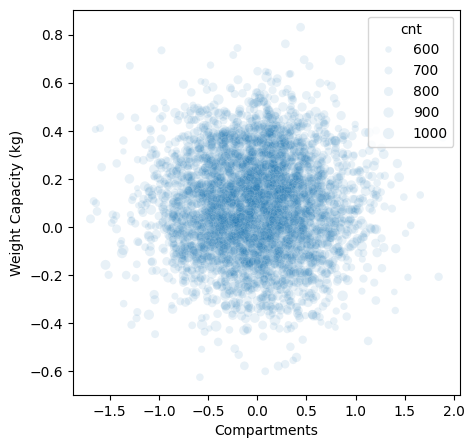

In [61]:
_ = plt.figure(figsize = (5, 5))
df_lr_result = sc.cache_result(
    'lr_result_groupby_cat',
    lambda : df_train.groupby(X_cat, observed = True)[X_num + [target]].apply(
        lambda x: LinearRegression().fit(x[X_num], x[target])
    ).pipe(
        lambda x: x.apply(lambda x: pd.Series(x.coef_, index = X_num)).join(x.apply(lambda x: x.intercept_).rename('intecept'))
    )
).join(df_train[X_cat].value_counts().rename('cnt'))
sns.scatterplot(df_lr_result, x = X_num[0], y = X_num[1], alpha = 0.1, size = 'cnt')
plt.show()

<Axes: ylabel='Count'>

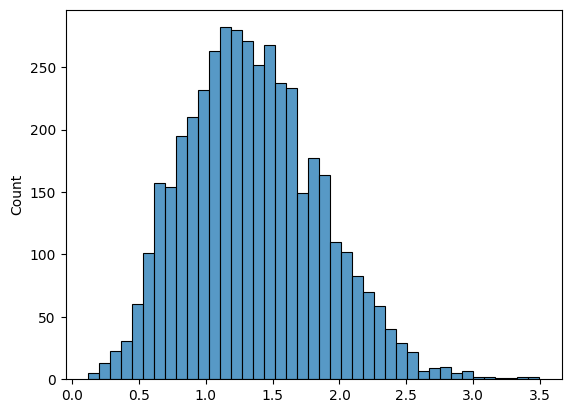

In [62]:
df_cv_lr_result = sc.cache_result(
    'cv_lr_rmse_groupby_cat',
    lambda : df_train.groupby(X_cat, observed = True)[X_num + [target]].apply(
        lambda x: cross_val_score(LinearRegression(), x[X_num], x[target], cv = kf, scoring = 'neg_root_mean_squared_error')
    )
).apply(lambda x: pd.Series(x))
sns.histplot(df_cv_lr_result.std(axis=1))

In [63]:
df_cv_vs_std = pd.concat([
    (-df_cv_lr_result.mean(axis=1)).rename('rmse_lr'),
    df_train.groupby(X_cat, observed=True)[target].apply(
        lambda x: x.sample(frac = 0.8).pipe(lambda y: ((x.loc[~x.index.isin(y.index)] - y.mean()) ** 2).mean() ** 0.5)
    ).rename('std')
], axis=1).join(
    df_train[X_cat].value_counts(normalize = True).rename('w')
)
(df_cv_vs_std['rmse_lr'] - df_cv_vs_std['std']).dot(
    df_cv_vs_std['w']
)

0.04707472495709205

In [64]:
df_cv_vs_std['rmse_lr'].dot(df_cv_vs_std['w']), df_cv_vs_std['std'].dot(df_cv_vs_std['w'])

(38.866141451454084, 38.81906672649698)

## Estimating the feature importance & interaction using CatBoost

In [67]:
hparams = {
    'model_params' : {'n_estimators': 300},
    'X_num': X_num, 'X_cat': X_cat
}
result = sc.cache_result(
    'cb_im_in',
    lambda : sgml.cv(df_train.dropna(), ss, hparams, config, cb_adapter, result_proc=[sgml.cb_learning_result, sgml.cb_interaction_importance])
)
result['valid_scores']

[38.753981802006024]

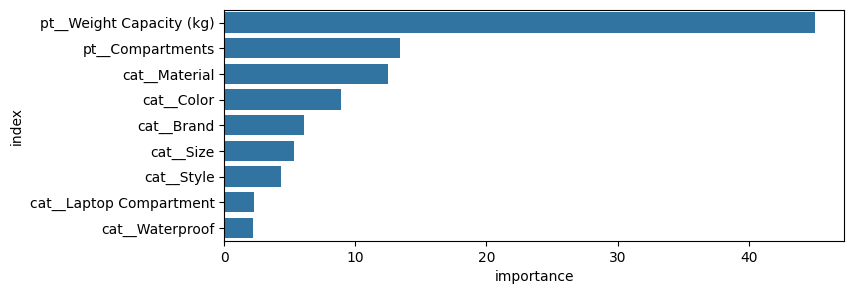

In [68]:
plt.figure(figsize=(8, 3))
sns.barplot(
    result['model_result'][0]['feature_importance'].sort_values(ascending = False).rename('importance').to_frame().reset_index(), 
    y = 'index', x = 'importance'
)
plt.show()

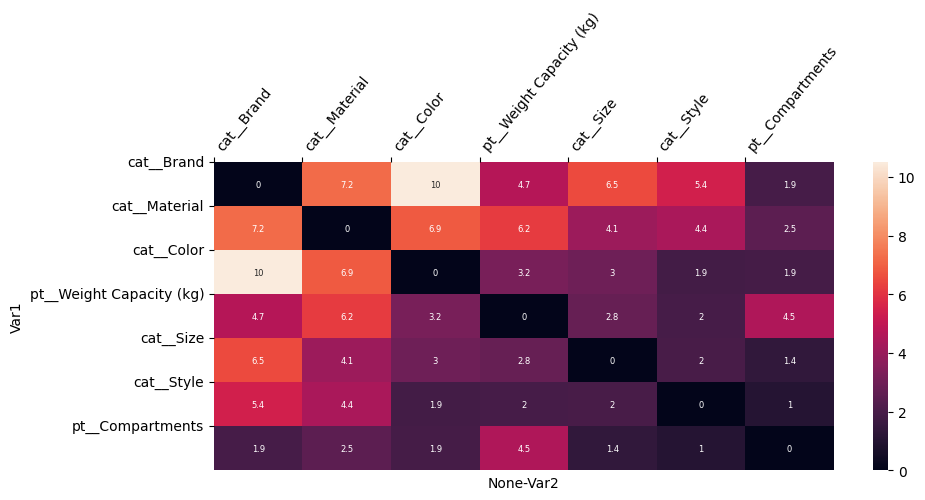

In [69]:
df_cb_inter = pd.concat([
    result['model_result'][1],
    result['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 4))
sns.heatmap(df_cb_inter, annot=True, annot_kws = {'size': 6})
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

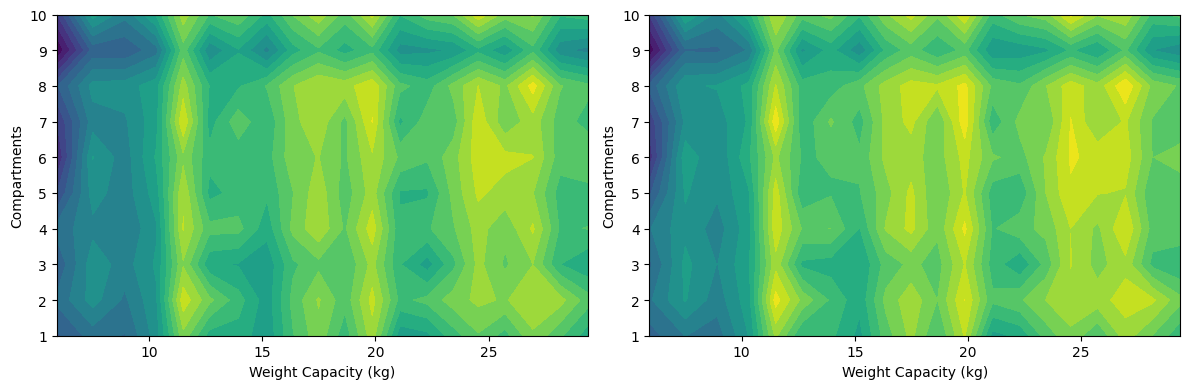

In [70]:
# We haven't investigated the interaction between Compartments and Weight Capacity. Let's visualize their interaction.
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
df_train.assign(
    wt100 = lambda x: pd.qcut(x['Weight Capacity (kg)'], q = 20, duplicates = 'drop').pipe(lambda x: x.apply(lambda x: x.left + x.right).astype(float) / 2)
).groupby(['Compartments', 'wt100'], observed=True)[target].mean().unstack().pipe(
    lambda x: axes[0].contourf(*np.meshgrid(x.columns, x.index), x.values, cmap = 'viridis', levels = 20)
)
axes[0].set_xlabel('Weight Capacity (kg)')
axes[0].set_ylabel('Compartments')

# Through a Kruskal analysis of the association between categorical variables and the Target, Material showed high association. 
# To remove the influence of these categorical variables, we plot graphs of the Target's mean and the deviation from the overall Target for each of these four variables.
df_train.assign(
    wt100 = lambda x: pd.qcut(x['Weight Capacity (kg)'], q = 20, duplicates = 'drop').pipe(lambda x: x.apply(lambda x: x.left + x.right).astype(float) / 2),
    target_diff = lambda x: x[target] - x.groupby(['Material'], observed=True)[target].transform('mean')
).groupby(['Compartments', 'wt100'], observed=True)['target_diff'].mean().unstack().pipe(
    lambda x: axes[1].contourf(*np.meshgrid(x.columns, x.index), x.values, cmap = 'viridis', levels = 20)
)
axes[1].set_xlabel('Weight Capacity (kg)')
axes[1].set_ylabel('Compartments')
plt.tight_layout()
plt.show()

When comparing the data with and without the influence of the categorical variables, similar trends are observed. The interaction between the two variables appears to be a globally valid phenomenon, and once the influence of the categorical variables is removed, the mutual association between the two variables becomes more pronounced.

It would be better to regard Compartments as categorical variable.

In [71]:
kruskal(*df_train.groupby('Compartments')[target].agg(list))

KruskalResult(statistic=462.54695697649146, pvalue=5.951059347209096e-94)

In [72]:
df_train['Compartments_c'] = df_train['Compartments'].astype('category')
df_train['wt_ic'] = df_train['Weight Capacity (kg)'].fillna(df_train['Weight Capacity (kg)'].median()).round().astype('int').astype('category')

In [75]:
rmse_comb_cat_list = sc.cache_result(
    'comb_cat_rmse2',
    lambda : [
        get_comb_cat_rmse_tgt(i, ss, X_cat + ['wt_ic', 'Compartments_c']) for i in range(1, 5)
    ], rerun = 1
)
for i in rmse_comb_cat_list:
    display(i.iloc[:5])

wt_ic             38.774477
Color             38.776183
Material          38.779321
Brand             38.779404
Compartments_c    38.782446
dtype: float64

Color     wt_ic    38.767572
Material  wt_ic    38.770530
Brand     wt_ic    38.770718
Material  Color    38.771576
Brand     Color    38.771769
dtype: float64

Material            Color     wt_ic    38.765344
Brand               Material  Color    38.766866
                    Color     wt_ic    38.767690
Laptop Compartment  Color     wt_ic    38.767875
Brand               Material  wt_ic    38.768194
dtype: float64

Brand     Material    Waterproof          Color    38.767333
Material  Waterproof  Color               wt_ic    38.767685
Brand     Material    Size                Color    38.767807
                      Laptop Compartment  Color    38.767930
                      Style               Color    38.768585
dtype: float64

In [ ]:
rmse_tgt_enc_cat(['wt_ic', 'Compartments_c'], cv = ss)

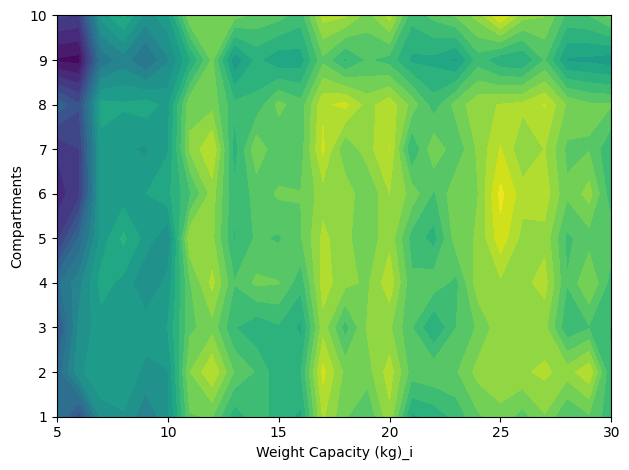

In [76]:
df_train.assign(
    wt_i = lambda x: x['Weight Capacity (kg)'].round(),
    target_diff = lambda x: x[target] - x.groupby(['Material'], observed=True)[target].transform('mean')
).groupby(['Compartments', 'wt_i'], observed=True)['target_diff'].mean().unstack().pipe(
    lambda x: plt.contourf(*np.meshgrid(x.columns, x.index), x.values, cmap = 'viridis', levels = 20)
)
plt.xlabel('Weight Capacity (kg)_i')
plt.ylabel('Compartments')
plt.tight_layout()
plt.show()

# Imputation of missing values

## Simple Impute: mode

In [77]:
from sklearn.impute import SimpleImputer
X_imp = df_train.isna().sum().pipe(lambda x: x.loc[x > 0]).index.tolist()
X_imp

['Brand',
 'Material',
 'Size',
 'Laptop Compartment',
 'Waterproof',
 'Style',
 'Color',
 'Weight Capacity (kg)']

In [78]:
df_imp = sgpp.ApplyWrapper(
    SimpleImputer(strategy = 'most_frequent').set_output(transform='pandas'),
    X_imp[:-1]
).fit_transform(df_train)

In [80]:
hparams = {
    'model_params' : {'n_estimators': 300, 'learning_rate': 0.05},
    'X_num': X_num, 'X_cat': X_cat,
    #'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb_simple_impute_2',
    lambda : sgml.cv(df_imp, ss, hparams, config, cb_adapter, result_proc=[sgml.cb_learning_result, sgml.cb_interaction_importance], task_type = 'GPU'),
    rerun = 1
)
np.mean(result['valid_scores'])

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

38.87677987023293

## Simple Impute: to Unknown

In [81]:
df_imp = sgpp.ApplyWrapper(
    sgpp.CatArrangerFreq(1, na_value = 'Unknown'),
    X_imp[:-1]
).fit_transform(df_train)

In [82]:
hparams = {
    'model_params' : {'n_estimators': 300, 'learning_rate': 0.05},
    'X_num': X_num, 'X_cat': X_cat,
    #'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb_simple_impute',
    lambda : sgml.cv(df_imp, ss, hparams, config, cb_adapter, result_proc=[sgml.cb_learning_result, sgml.cb_interaction_importance], task_type = 'GPU'),
    rerun = 0
)
np.mean(result['valid_scores'])

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

38.85501367891737

## LGB Iterative Impute

In [83]:
lgb_iter_imp = sgpp.ApplyWrapper(
    sgpp.LGBMIterativeImputer(
        hparams = {'n_estimators': 300, 'learning_rate': 0.05}, X_num = X_num, X_cat = X_cat, 
        targets = X_imp,
        n_iter = 2, validation_fraction = 0.1
    ), vals = X_num + X_cat
)

In [84]:
lgb_iter_imp = sc.cache_result(
    'lgb_imputer',
    lambda : lgb_iter_imp.fit(pd.concat([
        df_train[X_num + X_cat],
        df_test[X_num + X_cat]
    ])), rerun = 0
)
df_imp = lgb_iter_imp.transform(df_train)

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Step:   0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
hparams = {
    'model_params' : {'n_estimators': 300, 'learning_rate': 0.05},
    'X_num': X_num, 'X_cat': X_cat,
    #'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb_lgb_iter_impute',
    lambda : sgml.cv(df_imp, kf, hparams, config, cb_adapter, result_proc=[sgml.cb_learning_result, sgml.cb_interaction_importance], task_type = 'GPU'),
    rerun = 0
)
np.mean(result['valid_scores'])

# Including original dataset